In [1]:
# load and filter osm network (step 1)
import geopandas as gpd
import pandas as pd
import os, sys, time
import GOSTnet as gn
import networkx as nx
import osmnx as ox
from shapely.ops import unary_union
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString, Point

In [2]:
GISFolder = os.getcwd()
GISFolder

'C:\\Users\\grace\\GIS\\puerto rico'

In [3]:
pth = os.path.join(GISFolder, "morocco_data")
pth

'C:\\Users\\grace\\GIS\\puerto rico\\morocco_data'

In [ ]:
# original from Jo
# osm pbf last downloaded on: 02.17.20
fil = r'morocco-latest.osm.pbf'
f = os.path.join(pth, fil)
f

import load_osm as losm
mar = losm.OSM_to_network(f)

In [4]:
aoi = r'tinghir_bounding84.shp' 
# Created a rectangular bounding box (in QGIS) to use as the AOI

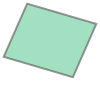

In [5]:
shp = gpd.read_file(os.path.join(pth, aoi))
bound = shp.geometry.iloc[0]
bound # Check that the shape looks right

In [14]:
!conda install geopandas=0.6.3
# Had type error on CRS argument in graph_from_polygon (below). Solution from StackOverflow: 
# Looks like Geopandas 0.7 updated their CRS object type to be a pyproj.CRS instead of a string. The osmnet library was having a similar issue. You can resolve this by reverting to an older version of geopandas:

^C


In [6]:
gDrive = ox.graph_from_polygon(bound, network_type= 'drive')

In [ ]:
# create standard speed dict
speedDict = {
                'residential': 30,  # kmph
                'primary': 60, # kmph
                'primary_link':55,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 50, # kmph
                'secondary_link':45,
                'tertiary':40,
                'tertiary_link': 35,
                'unclassified':30, 
                'road':20,
                'crossing':20,
                'living_street':10
    
                } 

In [ ]:
# convert graph network to time. use factor of 1000 to convert from km to meters
G_time = gn.convert_network_to_time(gDrive, 
                                    distance_tag = 'length', 
                                    speed_dict = speedDict, 
                                    factor = 1000)

In [13]:
nx.info(G_time)

'Name: unnamed\nType: MultiDiGraph\nNumber of nodes: 21527\nNumber of edges: 61087\nAverage in degree:   2.8377\nAverage out degree:   2.8377'

In [19]:
from shapely import geometry

villages = os.path.join(GISFolder, "morocco_data", "Tinghir_Villages.csv")
villages = pd.read_csv(villages)
geometry = [Point(xy) for xy in zip(villages.XWGS84, villages.YWGS84)]

In [ ]:
crs = {'init': 'epsg:4326'} 
villages = gpd.GeoDataFrame(villages, crs=crs, geometry=geometry)
villages.to_file(driver='ESRI Shapefile', filename='villages84.shp') 
villages.info()

In [21]:
villages.head()

,X,Y,FID_1,PROVINCE,CODE_PRO,CERCLE,CODE_CER,COMMUNE,CODE_COM,FRACTION,...,PROVINCE_1,REGION,Com_Arabe,Cer_Arabe,Prov_Arabe,Reg_arabe,Code_COM_1,CODE_A,Shape_Leng,geometry
0,846814.4513,3.461967e+06,4642,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,TINGHIR,SOUSS - MASSA - DRAA,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.35912 31.24042)
1,851811.8074,3.456718e+06,6455,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,TINGHIR,SOUSS - MASSA - DRAA,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.30858 31.19167)
2,850772.0843,3.476372e+06,11413,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,TINGHIR,SOUSS - MASSA - DRAA,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.31259 31.36894)
3,857317.9017,3.466820e+06,19798,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,TINGHIR,SOUSS - MASSA - DRAA,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.24732 31.28095)
4,853808.5600,3.476155e+06,21798,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,TINGHIR,SOUSS - MASSA - DRAA,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.28080 31.36607)


In [23]:
villages_snap = gn.pandana_snap(G_time, 
                           villages, 
                           source_crs='epsg:4326', 
                           target_crs='epsg:4326', 
                           add_dist_to_node_col=True)

C:\Users\grace\GIS\puerto rico\GOSTnet.py:1637: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  G_tree = spatial.KDTree(node_gdf[['x','y']].as_matrix())
C:\Users\grace\GIS\puerto rico\GOSTnet.py:1639: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indices = G_tree.query(in_df[['x','y']].as_matrix())


In [24]:
villages_snap.head()

,X,Y,FID_1,PROVINCE,CODE_PRO,CERCLE,CODE_CER,COMMUNE,CODE_COM,FRACTION,...,Com_Arabe,Cer_Arabe,Prov_Arabe,Reg_arabe,Code_COM_1,CODE_A,Shape_Leng,geometry,NN,NN_dist
0,846814.4513,3.461967e+06,4642,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.35912 31.24042),6914924272,0.081365
1,851811.8074,3.456718e+06,6455,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.30858 31.19167),2422205506,0.056640
2,850772.0843,3.476372e+06,11413,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.31259 31.36894),3526595200,0.019169
3,857317.9017,3.466820e+06,19798,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.24732 31.28095),6908244910,0.055522
4,853808.5600,3.476155e+06,21798,OUARZAZATE,401,BOUMALNE DADES,401.05,AIT EL FARSI,401.05.01,OUEDICHEN,...,NaN,NaN,NaN,NaN,1,04.401.05.01,115992.504936,POINT (-5.28080 31.36607),3526595185,0.006065
